In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/EC523Project"
#!ls "/content/drive/Shared with me/EC523Project"

 Augmented_data				    'EC 523 Project.gdoc'	     lits_train.csv
 Augmented_data_original+3transforms	    'EC 523 Project Proposal.gdoc'   SegmentationData
 AutoLiverCancerDetection.ipynb		     lits_df.csv		     VolumeData
'Copy of EC 523 Project Proposal (1).gdoc'   lits_probe.csv
'Copy of EC 523 Project Proposal.gdoc'	     lits_test.csv


# Training and Test Datasets

**Load the Data**

In [ ]:
import torch
import torchio as tio
from torchio import AFFINE, DATA, PATH, TYPE, STEM


In [ ]:
import pickle

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Augmented_data_original+3transforms/augmented_dataset.pkl'
# Open the file in read-binary mode and load the dataset
with open(file_path, 'rb') as file:
    augmented_dataset = pickle.load(file)


In [ ]:
print(len(augmented_dataset))

524


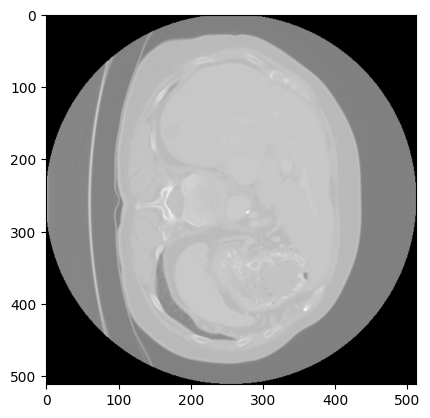

In [ ]:
import matplotlib.pyplot as plt

subject = augmented_dataset[1]

# Access the CT image tensor in the first subject
ct_image_tensor = subject['ct'][tio.DATA]

# Convert the tensor to a NumPy array
ct_image_array = ct_image_tensor.numpy()

# Select a 2D slice from the 3D CT image to display
ct_slice = ct_image_array[0, :, :, ct_image_array.shape[3] // 2]

# Display the slice using Matplotlib
plt.imshow(ct_slice, cmap='gray')
plt.show()


**Hyperparameters**

In [ ]:
params = {
    'batch_size': 4,
    'deep_supervision': False
}

In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(augmented_dataset, test_size=0.2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

# TransUNet


In [ ]:
import torch
import torch.nn as nn
from transformers import ViTFeatureExtractor, ViTModel

class UNetEncoder(nn.Module):
    def __init__(self, in_channels):
        super(UNetEncoder, self).__init__()

        self.enc_conv0 = ConvBlock(in_channels, 64, 64)
        self.pool0 = nn.MaxPool2d(2, 2)
        self.enc_conv1 = ConvBlock(64, 128, 128)
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # Forward pass through U-Net encoder
        x1 = self.enc_conv0(x)
        x = self.pool0(x1)
        x2 = self.enc_conv1(x)
        x = self.pool1(x2)

        return x, [x1, x2]


In [ ]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.up(x)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv(x)
        return x


In [ ]:
class TransUNet(nn.Module):
    def __init__(self, num_classes, vit_name='google/vit-base-patch16-224', in_channels=3):
        super(TransUNet, self).__init__()

        self.unet_encoder = UNetEncoder(in_channels)
        self.vit = ViTModel.from_pretrained(vit_name)

        self.upconv1 = UpConvBlock(vit_channels + 128, 128)  # Adjust the channel numbers as needed
        self.upconv2 = UpConvBlock(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        encoder_output, skip_connections = self.unet_encoder(x)
        n, c, h, w = encoder_output.shape
        transformer_input = encoder_output.permute(0, 2, 3, 1).view(n, h * w, c)
        transformer_output = self.vit(inputs_embeds=transformer_input).last_hidden_state

        decoder_output = self.upconv1(transformer_output, skip_connections[-1])
        decoder_output = self.upconv2(decoder_output, skip_connections[-2])

        map = self.final_conv(decoder_output)
        return map


# Loss

In [ ]:
!pip install torch torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.9 MB/s eta 0:00:00


In [ ]:
#dice loss definition
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module): #just set this as the criterion, like criterion = DiceLoss()
  def __init__(self):
    super(DiceLoss, self).__init__()

  def forward(self, input, target):
    smooth=1e-5 #this is just to avoid divide by 0
    input_flat = input.view(-1) #flatten input
    target_flat = target.view(-1) #flatten true labels
    intersection = (input_flat*target_flat).sum()
    return 1 - ((2.0*intersection+smooth)/(input_flat.sum()+target_flat.sum()+smooth))

# Training and Testing

In [ ]:
subject = augmented_dataset[3]

# Access the CT image tensor in the first subject
ct_image_tensor = subject['ct'][tio.DATA]

print(ct_image_tensor.size())

In [ ]:
print(subject['mask'].shape)

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((512, 512)),
])

resize_augmented = tio.SubjectsDataset(augmented_dataset, transform=transform)
loader = DataLoader(resize_augmented, batch_size=4, shuffle=True)

In [ ]:
loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=3, shuffle=True)

In [ ]:
#training and testing functions
import torchmetrics
from torchmetrics.functional.detection import intersection_over_union
import torch.optim as optim

def train_model(model, train_loader, num_epochs, optimizer, criterion, device):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_iou = 0.0
        for batch, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                iou_val = intersection_over_union(outputs, labels)
                total_iou += iou_val.item()

            total_loss += loss.item()
            if batch % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch+1}/{len(train_loader)}], Loss: {loss.item():.4f}, IoU: {iou_val.item():.4f}')

        average_loss = total_loss / len(train_loader)
        average_iou = total_iou / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}, Average IoU: {average_iou:.4f}')


def test_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for batch, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iou_val = intersection_over_union(outputs, labels)

            total_loss += loss.item()
            total_iou += iou_val.item()

        average_loss = total_loss / len(val_loader)
        average_iou = total_iou / len(val_loader)
        print(f'Test Loss: {average_loss:.4f}, Test IoU: {average_iou:.4f}')


In [ ]:
#train the model
model = TransUNet(num_classes=num_classes, vit_name='google/vit-base-patch16-224', in_channels=input_channels)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
train_model(model, loader, num_epochs, optimizer, criterion, device)

In [ ]:
#test the model
test_model(model, val_loader, criterion)